<a href="https://colab.research.google.com/github/marcuuus/AMD-SM2L-20-21-RIVA/blob/main/project_Riva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DOWNLOAD OF THE DATASET.

In [ ]:
!mkdir /root/.kaggle

In [ ]:
!echo '{"username":"marcuus96","key":"ca8a06de4d10013b1a150c0e7026cf37"}' > /root/.kaggle/kaggle.json

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download jeffheaton/glasses-or-no-glasses

100% 6.11G/6.11G [02:12<00:00, 30.3MB/s]
100% 6.11G/6.11G [02:12<00:00, 49.4MB/s]


In [ ]:
!unzip /content/glasses-or-no-glasses.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: faces-spring-2020/faces-spring-2020/face-100.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1000.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1001.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1002.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1003.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1004.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1005.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1006.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1007.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1008.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1009.png  
  inflating: faces-spring-2020/faces-spring-2020/face-101.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1010.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1011.png  
  inflating: faces-spring-2020/faces-sprin

DATASET PREPARATION AND DATA CLEANING.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from matplotlib import pyplot as plt
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import itertools
from IPython.display import display, Javascript, clear_output, HTML

from ipywidgets import interact
import ipywidgets as widgets

import os, re, math, json, shutil, pprint

The test set doesn't have a label associated to the image, so the first thing to do is create one for all the test images.

The second thing to do is check the correcteness of the labels in the train set. I noticed that some labels in the train set are wrong, so I checked by hand if each label was right. I created a text file with the new labels, named label_train.txt (attached in the github repository), and I uploaded it in the notebook. I did the same thing for the test's labels

In [ ]:
!npx degit https://github.com/marcuuus/AMD-SM2L-20-21-RIVA -f

npx: installed 1 in 2.419s
> destination directory is not empty. Using --force, continuing
> cloned marcuuus/AMD-SM2L-20-21-RIVA#HEAD


In [ ]:
# Creation of the test label list
with open("/content/test_labels.txt", "r") as tl:
  label_test_list = tl.readlines()
label_test_list = [x.strip() for x in label_test_list]

In [ ]:
# Creation of the train label list
with open("/content/train_labels.txt", "r") as tl:
  label_train_list = tl.readlines()
label_train_list = [x.strip() for x in label_train_list]

In [ ]:
# Creation of the label column named "glasses" in test.csv. a new csv file is created

def add_csv_column(csv_file, input_file):
  df = pd.read_csv(csv_file)
  df['glasses'] = input_file
  df.to_csv('/content/new_' + csv_file, float_format='%.6g', index = False)

In [ ]:
add_csv_column('test.csv', label_test_list)

In [ ]:
# Correction of the label column in train.csv. a new csv file is created

def modify_csv_column(csv_file, input_file):
  df = pd.read_csv(csv_file)
  
  for i in itertools.count(0):
    if i == len(input_file):
      break
    df.loc[i, 'glasses'] = input_file[i]

  df.to_csv('/content/new_' + csv_file, float_format='%.6g', index = False)

In [ ]:
modify_csv_column('train.csv', label_train_list)

In [ ]:
train_file_path = "/content/new_train.csv"
test_file_path = "/content/new_test.csv"

In [ ]:
!mkdir /content/faces
!mkdir /content/faces/train
!mkdir /content/faces/test
!mkdir /content/faces/train/glasses
!mkdir /content/faces/train/no_glasses
!mkdir /content/faces/test/glasses
!mkdir /content/faces/test/no_glasses

In [ ]:
train = pd.read_csv(train_file_path).copy()

glasses = list()
no_glasses = list()

for i,img in train.iterrows():
  if img['glasses'] == 1:
    glasses.append(int(img['id']))
  if img['glasses'] == 0:
    no_glasses.append(int(img['id']))

In [ ]:
for id in glasses:
  os.system('mv /content/faces-spring-2020/faces-spring-2020/face-' + str(id) + '.png /content/faces/train/glasses')

for id in no_glasses:
  os.system('mv /content/faces-spring-2020/faces-spring-2020/face-' + str(id) + '.png /content/faces/train/no_glasses')

In [ ]:
test = pd.read_csv(test_file_path).copy()

glasses = list()
no_glasses = list()

for i,img in test.iterrows():
  if img['glasses'] == 1:
    glasses.append(int(img['id']))
  if img['glasses'] == 0:
    no_glasses.append(int(img['id']))

In [ ]:
for id in glasses:
  os.system('mv /content/faces-spring-2020/faces-spring-2020/face-' + str(id) + '.png /content/faces/test/glasses')

for id in no_glasses:
  os.system('mv /content/faces-spring-2020/faces-spring-2020/face-' + str(id) + '.png /content/faces/test/no_glasses')

CREATION OF THE DATASET

During the chek of the images I noticed that some of them were really ambiguous, so I remove them from the dataset. I put the label of these images to -1, so they aren't considered in the computation.

In [13]:
BATCH_SIZE = 64
EPOCHS = 10
IMG_SIZE = (160, 160)
CLASS_NAMES = ['glasses', 'no_glasses']

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

def get_training_ds():
  dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/faces/train/',
    image_size = IMG_SIZE,
    shuffle = True,
    batch_size = BATCH_SIZE)
  dataset = dataset.cache().shuffle(1000).prefetch(tf.data.experimental.AUTOTUNE)

  return dataset

def get_validation_ds():
  dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/faces/test/',
    image_size = IMG_SIZE,
    shuffle = True,
    batch_size = BATCH_SIZE)
  dataset = dataset.cache().prefetch(tf.data.experimental.AUTOTUNE)

  return dataset

EXAMPLE OF VISUALIZATION

using the train set, I visualize a list of couple (image, label)

In [ ]:
ex = get_training_ds()

for example in ex.take(1):
  images, labels = example
  break

Found 4469 files belonging to 2 classes.


In [ ]:
def visualize_image(images, labels, num, valid_labels):

  path = list()

  for i in itertools.count(0):
    if i == num:
      break

    else:
      image = images[i]
      label = labels[i]
      valid_label = valid_labels[i]

      if label == valid_label:
        wrong = False
      else:
        wrong = True

      path.append((image, label, wrong))
  
  y = 5
  x = int(math.ceil(len(path)/y))
  x_img = 0
  y_img =0

  f, axarr = plt.subplots(x,y, figsize=(20,20))
  plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=(num/5)/2.3, wspace=0.1, hspace=-0.7)
  
  for img in path:
    if x == 1:
      if img[2]:
        axarr[x_img].set_title(CLASS_NAMES[img[1]], fontsize = 20, color ='r')
      else:
        axarr[x_img].set_title(CLASS_NAMES[img[1]], fontsize = 20)

      axarr[x_img].axis("off")
      axarr[x_img].imshow(img[0].astype('uint8'))
    
    else:

      if y_img == y:
        y_img = 0
        x_img += 1

      if img[2]:
        axarr[x_img,y_img].set_title(CLASS_NAMES[img[1]], fontsize = 20, color = 'r')
      else:
        axarr[x_img,y_img].set_title(CLASS_NAMES[img[1]], fontsize = 20)

      axarr[x_img,y_img].axis("off")
      axarr[x_img,y_img].imshow(img[0].astype('uint8'))

    y_img += 1

  if (y_img-1) != (y-1):
    while(y_img != y):
      f.delaxes(axarr[x-1][y_img])
      y_img += 1


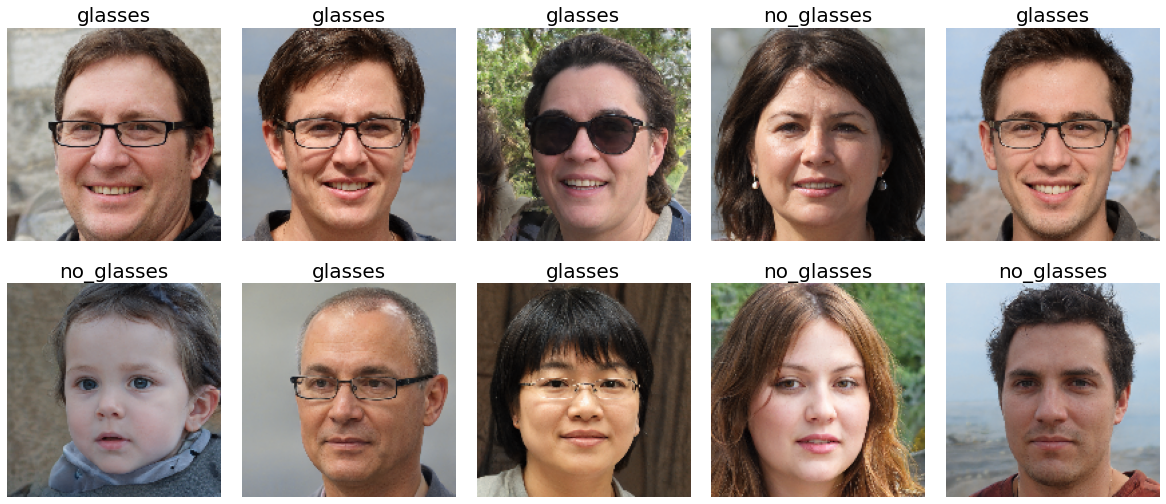

In [ ]:
visualize_image(images.numpy(), labels, 10, labels)

In [4]:
class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = 4500//BATCH_SIZE

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      (self.axes[0 if k.endswith('loss') else 1]
           .plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k))
      
    for k,v in self.epoch_history.items():
      (self.axes[0 if k.endswith('loss') else 1]
           .plot(np.array(self.epoch_step) / self.steps_per_epoch, v,
                 label=k, linewidth=3))
      
    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both',
                      linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both',
                      linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both',
                      linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both',
                      linestyle=':', linewidth=0.5)
    display(self.fig)


In [5]:
def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0],
                                                                      y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display(fig)

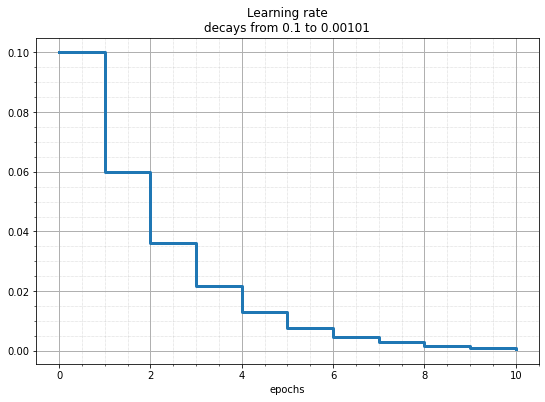

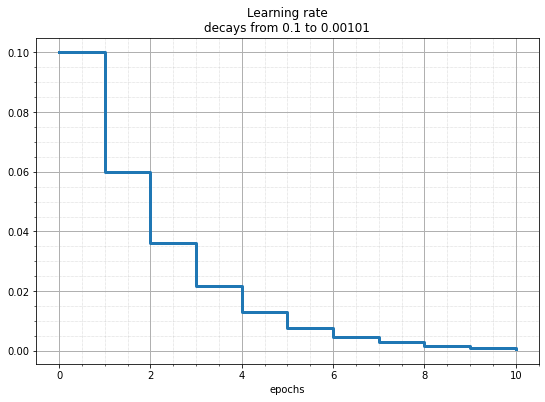

In [6]:
# lr decay function
def lr_decay(epoch):
  return 0.1 * math.pow(0.6, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

# important to see what you are doing
plot_learning_rate(lr_decay, EPOCHS)

CNN MODEL WITHOUT DROPOUT

In [17]:
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(160, 160, 3)),

  layers.Conv2D(16, 5, padding='same',),
  layers.BatchNormalization(center=True, scale=False),
  layers.Activation('relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 5, padding='same'),
  layers.BatchNormalization(center=True, scale=False),
  layers.Activation('relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 5, padding='same'),
  layers.BatchNormalization(center=True, scale=False),
  layers.Activation('relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),

  layers.Dense(128),
  layers.BatchNormalization(center=True, scale=False),
  layers.Activation('relu'),
  
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 160, 160, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 160, 160, 16)      1216      
_________________________________________________________________
batch_normalization_12 (Batc (None, 160, 160, 16)      48        
_________________________________________________________________
activation_12 (Activation)   (None, 160, 160, 16)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 80, 80, 32)        12832     
_________________________________________________________________
batch_normalization_13 (Batc (None, 80, 80, 32)       

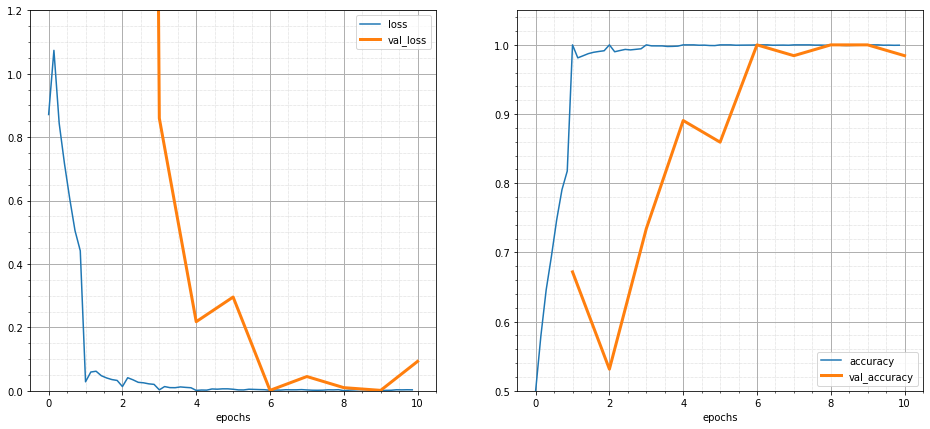

In [18]:
training_dataset = get_training_ds()

validation_dataset = get_validation_ds()

history = model.fit(training_dataset,
                    steps_per_epoch=4500//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    validation_steps=1,
                    callbacks=[plot_training, lr_decay_callback])

CNN MODEL WITH DROPOUT

In [15]:
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(160, 160, 3)),

  layers.Conv2D(16, 5, padding='same',),
  layers.BatchNormalization(center=True, scale=False),
  layers.Activation('relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 5, padding='same'),
  layers.BatchNormalization(center=True, scale=False),
  layers.Activation('relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 5, padding='same'),
  layers.BatchNormalization(center=True, scale=False),
  layers.Activation('relu'),
  layers.MaxPooling2D(),

  layers.Dropout(0.32),

  layers.Flatten(),

  layers.Dense(128),
  layers.BatchNormalization(center=True, scale=False),
  layers.Activation('relu'),
  
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 160, 160, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 160, 160, 16)      1216      
_________________________________________________________________
batch_normalization_8 (Batch (None, 160, 160, 16)      48        
_________________________________________________________________
activation_8 (Activation)    (None, 160, 160, 16)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 80, 80, 32)        12832     
_________________________________________________________________
batch_normalization_9 (Batch (None, 80, 80, 32)       

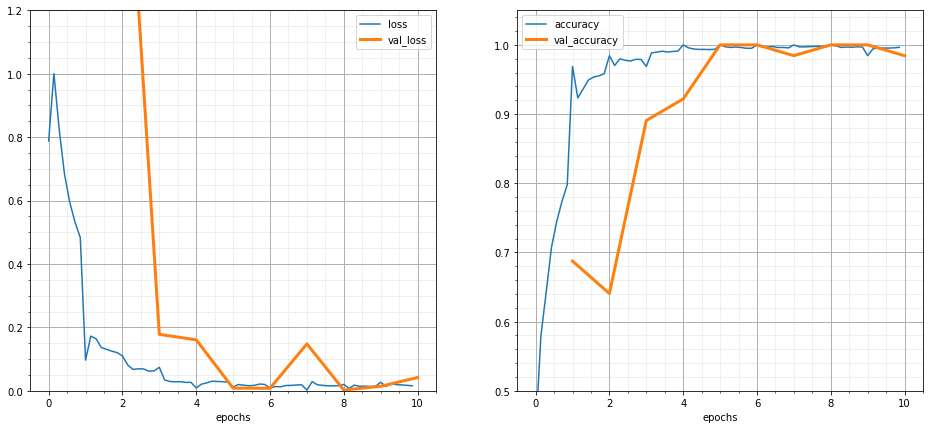

In [16]:
training_dataset = get_training_ds()

validation_dataset = get_validation_ds()

history = model.fit(training_dataset,
                    steps_per_epoch=4500//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    validation_steps=1,
                    callbacks=[plot_training, lr_decay_callback])

VISUALIZATION OF THE PREDICTIONS

In [ ]:
for validation_images, validation_labels in validation_dataset:
  validation_images = validation_images.numpy()
  validation_labels = validation_labels.numpy()
  break

In [ ]:
predictions = model.predict(validation_images, steps = 1)
predicted_labels = list()

for pred in predictions:
  if pred[0] < 0.25:
    predicted_labels.append(0)
  else:
    predicted_labels.append(1)

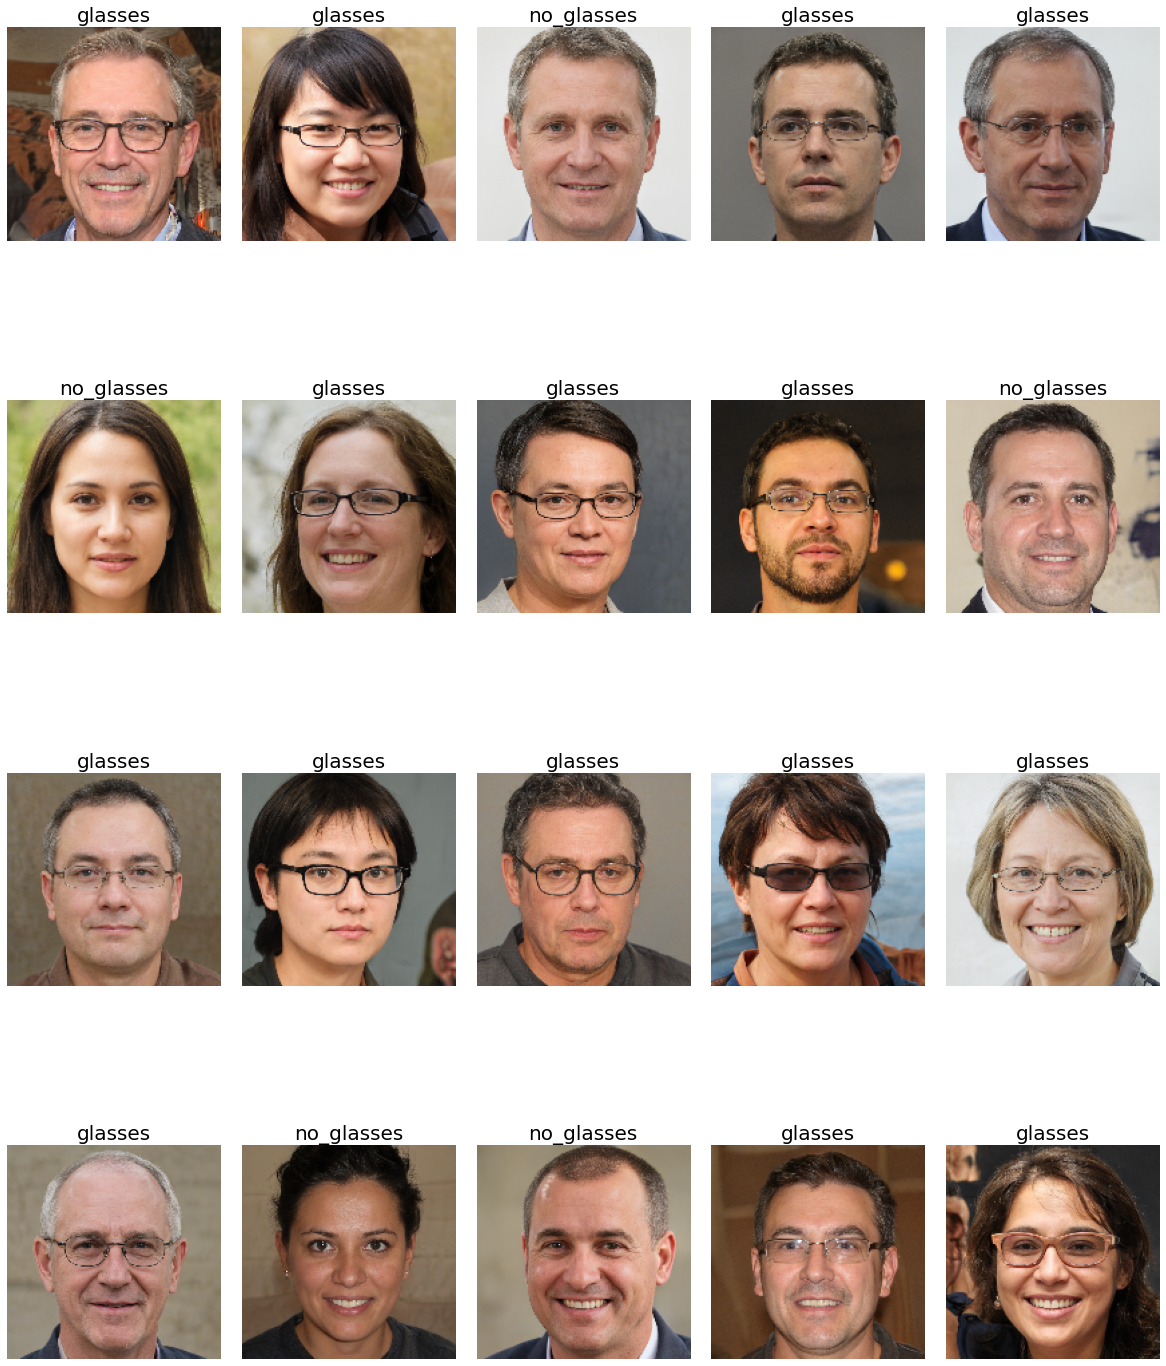

In [ ]:
visualize_image(validation_images, predicted_labels, 20, validation_labels)

PREDICTION WITH A PICTURE OF MYSELF

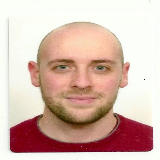

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread("/content/foto_tessera.jpeg")
res = cv2.resize(img, dsize=(160, 160))
cv2_imshow(res)
res = res.reshape(1, 160, 160, 3)

In [ ]:
io = model.predict(res, steps = 1)

if io < 0.25:
  print("GLASSES")
else:
  print("NO GLASSES")

NO GLASSES
